<a href="https://colab.research.google.com/github/k4404c/tensorflow_workbook/blob/main/tensorflow_foodvision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#to use mixed precision training we need a GPU with a score of 7.0+
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-99cc663c-7091-4c15-f67b-a04ecf66f3b3)


In [ ]:
!pip install -U -q tf-nightly

# Check TensorFlow version (should be minimum 2.4.0+ but 2.13.0+ is better)
import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")

# Add timestamp
import datetime
print(f"Notebook last run (end-to-end): {datetime.datetime.now()}")

In [4]:
import os

if not os.path.exists("helper_functions.py"):
    !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
else:
    print("[INFO] 'helper_functions.py' already exists, skipping download.")

from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

--2024-05-16 04:18:46--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-05-16 04:18:46 (117 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [94]:
#getting data from tf datasets
import tensorflow as tf
import tensorflow_datasets as tfds

#Load in food 101
(train_data, test_data), ds_info = tfds.load("food101",
                                             split=["train", "validation"],
                                             shuffle_files= True,
                                             as_supervised= True,
                                             with_info = True)

In [6]:
#Features of food101
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [7]:
#Get class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [95]:
#Take one sample of train data
train_one_sample = train_data.take(1)

train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [96]:

for image, label in train_one_sample:

  print(f"Image Shape: {image.shape}")
  print(f"Image Dytpe: {image.dtype}")
  print(f"Target class from Food101(tensor form): {label}")
  print(f"Class name (str form): {class_names[label.numpy()]}")


Image Shape: (512, 512, 3)
Image Dytpe: <dtype: 'uint8'>
Target class from Food101(tensor form): 21
Class name (str form): chocolate_cake


In [10]:
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[ 93,  34,  40],
        [ 93,  34,  40],
        [ 94,  35,  41],
        ...,
        [ 52,  15,  23],
        [ 52,  15,  23],
        [ 52,  15,  23]],

       [[ 93,  34,  40],
        [ 93,  34,  40],
        [ 94,  35,  41],
        ...,
        [ 52,  15,  23],
        [ 52,  15,  23],
        [ 52,  15,  23]],

       [[ 93,  34,  40],
        [ 93,  34,  40],
        [ 94,  35,  41],
        ...,
        [ 54,  14,  23],
        [ 52,  15,  23],
        [ 52,  15,  23]],

       ...,

       [[108,  31,  49],
        [106,  29,  47],
        [105,  28,  46],
        ...,
        [121,  38,  56],
        [122,  39,  59],
        [123,  40,  60]],

       [[107,  30,  48],
        [107,  30,  48],
        [107,  30,  48],
        ...,
        [121,  38,  58],
        [123,  40,  60],
        [123,  40,  60]],

       [[106,  29,  47],
        [108,  31,  49],
        [109,  32,  50],
        ...,
        [123,  40,  6

In [11]:
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=9>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

(-0.5, 511.5, 511.5, -0.5)

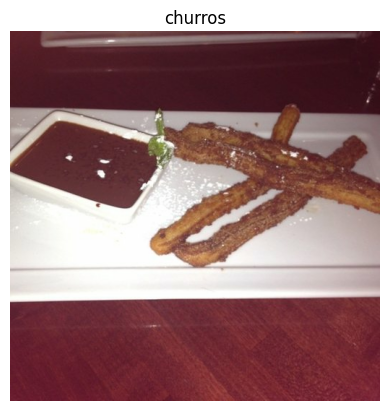

In [12]:
#Plot image tensor
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False)

In [13]:
#Prepare data for modeling

#NNs perfrom best when data is batched, normalized, etc
#Our data is in uint8, images are different sizes, pixel values are 0-255
#models like float16 or float32

#we are using efficienet, so we dont need to normalize data

#We need to: Reshape, change dtype

def prep_img(image,label, img_shape=224):
  img = tf.image.resize(image, [img_shape, img_shape])
  return tf.cast(img, tf.float32), label

In [14]:
prepped_img = prep_img(image, label)[0]
print(f"Image before proccessing:\n {image[:2]}, \nShape: {image.shape}, \nDtype: {image.dtype}")
print(f"Image after proccessing:\n {prepped_img[:2]}, \nShape: {prepped_img.shape}, \nDtype: {prepped_img.dtype}")

Image before proccessing:
 [[[93 34 40]
  [93 34 40]
  [94 35 41]
  ...
  [52 15 23]
  [52 15 23]
  [52 15 23]]

 [[93 34 40]
  [93 34 40]
  [94 35 41]
  ...
  [52 15 23]
  [52 15 23]
  [52 15 23]]], 
Shape: (512, 512, 3), 
Dtype: <dtype: 'uint8'>
Image after proccessing:
 [[[93.       34.       40.      ]
  [94.       35.       41.      ]
  [95.       36.       42.      ]
  ...
  [55.       15.       24.      ]
  [52.       15.       23.      ]
  [52.       15.       23.      ]]

 [[93.92857  34.928574 40.928574]
  [93.07143  34.071426 40.071426]
  [94.       35.       41.      ]
  ...
  [55.       15.       24.      ]
  [54.       14.       23.      ]
  [52.       15.       23.      ]]], 
Shape: (224, 224, 3), 
Dtype: <dtype: 'float32'>


In [15]:
#prepare datasets
train_data = train_data.map(map_func= prep_img, num_parallel_calls = tf.data.AUTOTUNE)

#Shuffle data and turn to batches
train_data = train_data.shuffle(buffer_size = 1000).batch(batch_size = 32).prefetch(buffer_size = tf.data.AUTOTUNE)


#Same for testing data
test_data = test_data.map(map_func= prep_img, num_parallel_calls = tf.data.AUTOTUNE)

#Shuffle data and turn to batches
test_data = test_data.shuffle(buffer_size = 1000).batch(batch_size = 32).prefetch(buffer_size = tf.data.AUTOTUNE)


In [15]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [16]:
#Making callbacks

#tensorboard callback
from helper_functions import create_tensorboard_callback

#model checkpoint callback
checkpoint_path = "model_checkpoint/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor = "val_acc",
                                                      save_best_only = True,
                                                      save_weights_only = True,
                                                      verbose = 0)

In [ ]:
!pip install tensorflow==2.4.1
tf.__version__

In [17]:
#Set up mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

In [18]:
!nvidia-smi

Thu May 16 04:30:44 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P0              29W /  70W |    105MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [19]:
mixed_precision.global_policy()

<Policy "mixed_float16">

In [20]:
##build feature extraction model
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

inputs = layers.Input(shape = input_shape, name = "input_layer")
#note efficienent models have rescaling, if we didnt we could have a layer like the one below:
#x = preprocessing.Rescaling(1/255.)(inputs)
x = base_model(inputs, training = False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype = tf.float32, name = "softmax_flaot32")(x) #New since we have mixed precision

model = tf.keras.Model(inputs, outputs)

#compile
model.compile(loss = "sparse_categorical_crossentropy",
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ["accuracy"])



16705208/16705208 [==============================] - 1s 0us/step


In [21]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_flaot32 (Activatio  (None, 101)               0         
 n)                                                              
                                                             

In [22]:
for layer in model.layers:
  print(f"layer name: {layer.name}, layer.dtype: {layer.dtype}, dtype policy: {layer.dtype_policy}, trainable: {layer.trainable}")

layer name: input_layer, layer.dtype: float32, dtype policy: <Policy "float32">, trainable: True
layer name: efficientnetb0, layer.dtype: float32, dtype policy: <Policy "mixed_float16">, trainable: False
layer name: global_average_pooling2d, layer.dtype: float32, dtype policy: <Policy "mixed_float16">, trainable: True
layer name: dense, layer.dtype: float32, dtype policy: <Policy "mixed_float16">, trainable: True
layer name: softmax_flaot32, layer.dtype: float32, dtype policy: <Policy "float32">, trainable: True


In [23]:
for layer in model.layers[1].layers[:20]:
  print(f"layer name: {layer.name}, layer.dtype: {layer.dtype}, dtype policy: {layer.dtype_policy}, trainable: {layer.trainable}")

layer name: input_1, layer.dtype: float32, dtype policy: <Policy "float32">, trainable: False
layer name: rescaling, layer.dtype: float32, dtype policy: <Policy "mixed_float16">, trainable: False
layer name: normalization, layer.dtype: float32, dtype policy: <Policy "mixed_float16">, trainable: False
layer name: rescaling_1, layer.dtype: float32, dtype policy: <Policy "mixed_float16">, trainable: False
layer name: stem_conv_pad, layer.dtype: float32, dtype policy: <Policy "mixed_float16">, trainable: False
layer name: stem_conv, layer.dtype: float32, dtype policy: <Policy "mixed_float16">, trainable: False
layer name: stem_bn, layer.dtype: float32, dtype policy: <Policy "mixed_float16">, trainable: False
layer name: stem_activation, layer.dtype: float32, dtype policy: <Policy "mixed_float16">, trainable: False
layer name: block1a_dwconv, layer.dtype: float32, dtype policy: <Policy "mixed_float16">, trainable: False
layer name: block1a_bn, layer.dtype: float32, dtype policy: <Policy "mi

In [24]:
#fit the model
his1 = model.fit(train_data,
          epochs = 3,
          steps_per_epoch = len(train_data),
          validation_data = test_data,
          validation_steps = int(0.15 * len(test_data)),
          callbacks = [model_checkpoint,
                       create_tensorboard_callback(dir_name = "training_logs",
                                                   experiment_name = "efficientnetb0_feature_extraxt_101")]
          )

Saving TensorBoard log files to: training_logs/efficientnetb0_feature_extraxt_101/20240516-043119
Epoch 1/3
2368/2368 [==============================] - ETA: 0s - loss: 1.7178 - accuracy: 0.5806

2368/2368 [==============================] - 112s 43ms/step - loss: 1.7178 - accuracy: 0.5806 - val_loss: 1.1376 - val_accuracy: 0.6981
Epoch 2/3
2367/2368 [============================>.] - ETA: 0s - loss: 1.1994 - accuracy: 0.6889

2368/2368 [==============================] - 101s 42ms/step - loss: 1.1994 - accuracy: 0.6889 - val_loss: 1.0364 - val_accuracy: 0.7161
Epoch 3/3
2368/2368 [==============================] - ETA: 0s - loss: 1.0542 - accuracy: 0.7230

2368/2368 [==============================] - 101s 42ms/step - loss: 1.0542 - accuracy: 0.7230 - val_loss: 0.9833 - val_accuracy: 0.7365


In [25]:
results_featue_extract = model.evaluate(test_data)

790/790 [==============================] - 32s 39ms/step - loss: 0.9918 - accuracy: 0.7330


In [27]:
#Save the model
!mkdir -p saved_model
model.save('saved_model/my_model_feature')

In [28]:
loaded_model = tf.keras.models.load_model('saved_model/my_model_feature')
loaded_model.evaluate(test_data)


790/790 [==============================] - 35s 41ms/step - loss: 0.9918 - accuracy: 0.7330


[0.9917535781860352, 0.7330297231674194]

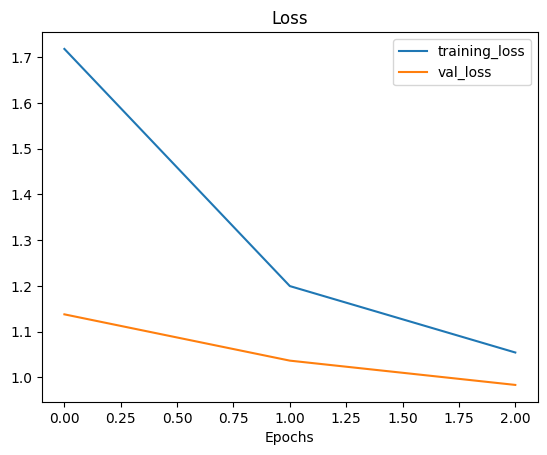

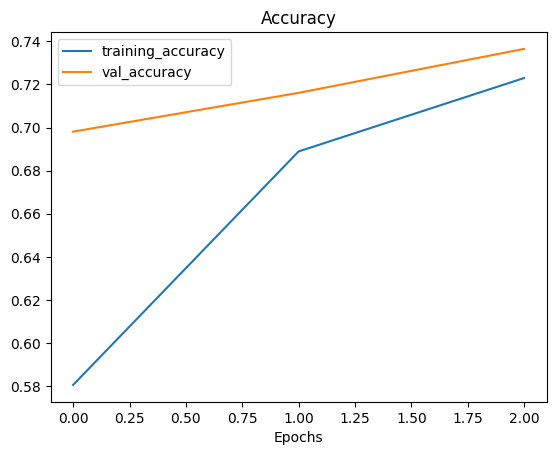

In [29]:
plot_loss_curves(his1)

In [30]:
base_model.trainable = True
for layer in model.layers:
  print(layer.name, layer.trainable)

for layer_num, layer in enumerate(model.layers[1].layers):
  print(layer_num, layer.name, layer.trainable)

input_layer True
efficientnetb0 True
global_average_pooling2d True
dense True
softmax_flaot32 True
0 input_1 True
1 rescaling True
2 normalization True
3 rescaling_1 True
4 stem_conv_pad True
5 stem_conv True
6 stem_bn True
7 stem_activation True
8 block1a_dwconv True
9 block1a_bn True
10 block1a_activation True
11 block1a_se_squeeze True
12 block1a_se_reshape True
13 block1a_se_reduce True
14 block1a_se_expand True
15 block1a_se_excite True
16 block1a_project_conv True
17 block1a_project_bn True
18 block2a_expand_conv True
19 block2a_expand_bn True
20 block2a_expand_activation True
21 block2a_dwconv_pad True
22 block2a_dwconv True
23 block2a_bn True
24 block2a_activation True
25 block2a_se_squeeze True
26 block2a_se_reshape True
27 block2a_se_reduce True
28 block2a_se_expand True
29 block2a_se_excite True
30 block2a_project_conv True
31 block2a_project_bn True
32 block2b_expand_conv True
33 block2b_expand_bn True
34 block2b_expand_activation True
35 block2b_dwconv True
36 block2b_bn T

In [31]:
for layer in model.layers[1].layers[:20]:
  print(f"layer name: {layer.name}, layer.dtype: {layer.dtype}, dtype policy: {layer.dtype_policy}, trainable: {layer.trainable}")

layer name: input_1, layer.dtype: float32, dtype policy: <Policy "float32">, trainable: True
layer name: rescaling, layer.dtype: float32, dtype policy: <Policy "mixed_float16">, trainable: True
layer name: normalization, layer.dtype: float32, dtype policy: <Policy "mixed_float16">, trainable: True
layer name: rescaling_1, layer.dtype: float32, dtype policy: <Policy "mixed_float16">, trainable: True
layer name: stem_conv_pad, layer.dtype: float32, dtype policy: <Policy "mixed_float16">, trainable: True
layer name: stem_conv, layer.dtype: float32, dtype policy: <Policy "mixed_float16">, trainable: True
layer name: stem_bn, layer.dtype: float32, dtype policy: <Policy "mixed_float16">, trainable: True
layer name: stem_activation, layer.dtype: float32, dtype policy: <Policy "mixed_float16">, trainable: True
layer name: block1a_dwconv, layer.dtype: float32, dtype policy: <Policy "mixed_float16">, trainable: True
layer name: block1a_bn, layer.dtype: float32, dtype policy: <Policy "mixed_float

In [32]:
#Setting up early stopping callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss",
                                                           patience = 3,
                                                          )

In [33]:
model.compile(loss = "sparse_categorical_crossentropy",
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
              metrics = ["accuracy"])

fine_tune_epochs = 3 + 100
his2 = model.fit(train_data,
                 epochs = fine_tune_epochs,
                 steps_per_epoch = len(train_data),
                 validation_data = test_data,
                 validation_steps = int(0.15*len(test_data)),
                 initial_epoch = his1.epoch[-1],
                 callbacks = [create_tensorboard_callback(dir_name = "training_logs",
                                                   experiment_name = "efficientnetb0_fine_tuning_101"),
                              early_stopping_callback])

Saving TensorBoard log files to: training_logs/efficientnetb0_fine_tuning_101/20240516-044151
Epoch 3/103
2368/2368 [==============================] - 353s 131ms/step - loss: 0.8681 - accuracy: 0.7662 - val_loss: 0.7718 - val_accuracy: 0.7945
Epoch 4/103
2368/2368 [==============================] - 307s 129ms/step - loss: 0.5365 - accuracy: 0.8513 - val_loss: 0.7580 - val_accuracy: 0.7897
Epoch 5/103
2368/2368 [==============================] - 309s 130ms/step - loss: 0.3001 - accuracy: 0.9143 - val_loss: 0.8073 - val_accuracy: 0.7948
Epoch 6/103
2368/2368 [==============================] - 307s 129ms/step - loss: 0.1584 - accuracy: 0.9535 - val_loss: 0.9054 - val_accuracy: 0.7908
Epoch 7/103
2368/2368 [==============================] - 308s 130ms/step - loss: 0.1010 - accuracy: 0.9681 - val_loss: 0.9798 - val_accuracy: 0.7900


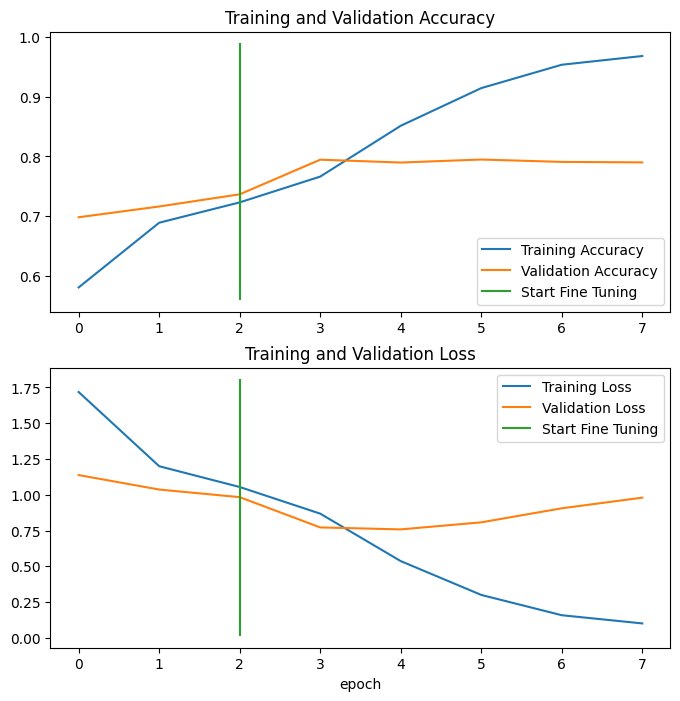

In [34]:
from helper_functions import compare_historys

compare_historys(his1,his2, initial_epochs=3)

In [35]:
(_, test_data_unshuffled), _ = tfds.load("food101",
                                             split=["train", "validation"],
                                             shuffle_files= False,
                                             as_supervised= True,
                                             with_info = True)

test_data_unshuffled = test_data_unshuffled.map(map_func= prep_img, num_parallel_calls = tf.data.AUTOTUNE)

#Shuffle data and turn to batches
test_data_unshuffled = test_data_unshuffled.batch(batch_size = 32).prefetch(buffer_size = tf.data.AUTOTUNE)


mod_evals = model.evaluate(test_data_unshuffled)
mod_evals

790/790 [==============================] - 28s 36ms/step - loss: 1.0338 - accuracy: 0.7810


[1.0338020324707031, 0.7809504866600037]

In [36]:
pred_probs = model.predict(test_data_unshuffled, verbose = 1)

790/790 [==============================] - 28s 33ms/step


In [37]:
pred_probs[0], len(pred_probs[0]), sum(pred_probs)

(array([6.8251749e-05, 3.2337050e-11, 9.3037583e-10, 4.4895549e-11,
        1.5165125e-07, 1.5165125e-07, 1.6846931e-09, 3.2152928e-10,
        3.4319139e-05, 2.9522810e-06, 1.2951907e-04, 1.1645020e-10,
        3.7748979e-08, 9.4416933e-03, 5.0009273e-08, 7.9579271e-10,
        1.2262618e-04, 7.5547803e-05, 3.6281167e-12, 3.6172105e-06,
        1.9009971e-11, 4.2289471e-06, 4.5016909e-06, 2.7034756e-07,
        2.1972539e-09, 3.9170285e-09, 6.9828587e-09, 1.7355566e-06,
        4.5533962e-08, 8.3347529e-01, 3.0114086e-04, 2.7792483e-05,
        5.2488219e-11, 2.7427717e-15, 4.5397084e-02, 4.0474564e-12,
        6.9430996e-08, 3.1163688e-10, 8.7034000e-12, 1.9696056e-09,
        5.5555283e-10, 1.1896135e-11, 1.1276494e-03, 3.0726758e-13,
        7.9579271e-10, 7.1677758e-04, 1.1222475e-09, 4.2175468e-11,
        8.4229343e-09, 1.3175688e-07, 2.6655714e-10, 9.7913393e-08,
        3.4226613e-10, 1.7528499e-05, 4.1998498e-13, 2.2191479e-08,
        2.2861474e-05, 1.7729826e-07, 9.1128044e

In [44]:
pred_classes= pred_probs.argmax(axis=1)
pred_classes[:10]

array([ 29,  81,  91,  53,  97,  97,  10,  31,   3, 100])

In [45]:
y_labels = []
for images, labels in test_data_unshuffled.unbatch():
  y_labels.append(labels.numpy()) #using argmax because it is hotencoded and 1 is at location of label
y_labels[:10]

[29, 81, 91, 53, 97, 97, 10, 31, 3, 100]

In [46]:
from sklearn.metrics import accuracy_score

sklearn_accuracy = accuracy_score(y_true = y_labels,
                                  y_pred = pred_classes)
sklearn_accuracy

0.780950495049505

In [48]:
from helper_functions import make_confusion_matrix

make_confusion_matrix(y_true = y_labels,
                      y_pred = pred_classes,
                      classes = class_names,
                      figsize = (100,100),
                      text_size = 10)

In [49]:
from sklearn.metrics import classification_report
class_report = classification_report(y_true = y_labels,
                      y_pred = pred_classes
)
#print(class_report)
class_report_dict = classification_report(y_true = y_labels,
                      y_pred = pred_classes,
                                          output_dict = True
)


In [50]:


#create empty dict
class_f1_scores = {}
for k, v in class_report_dict.items():
  if k == "accuracy":
    #stop once we get to accuracy key
    break
  else:
    class_f1_scores[class_names[int(k)]] = v["f1-score"]

#class_f1_scores

import pandas as pd
f1_scores = pd.DataFrame({"class_names": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending = False)
#f1_scores

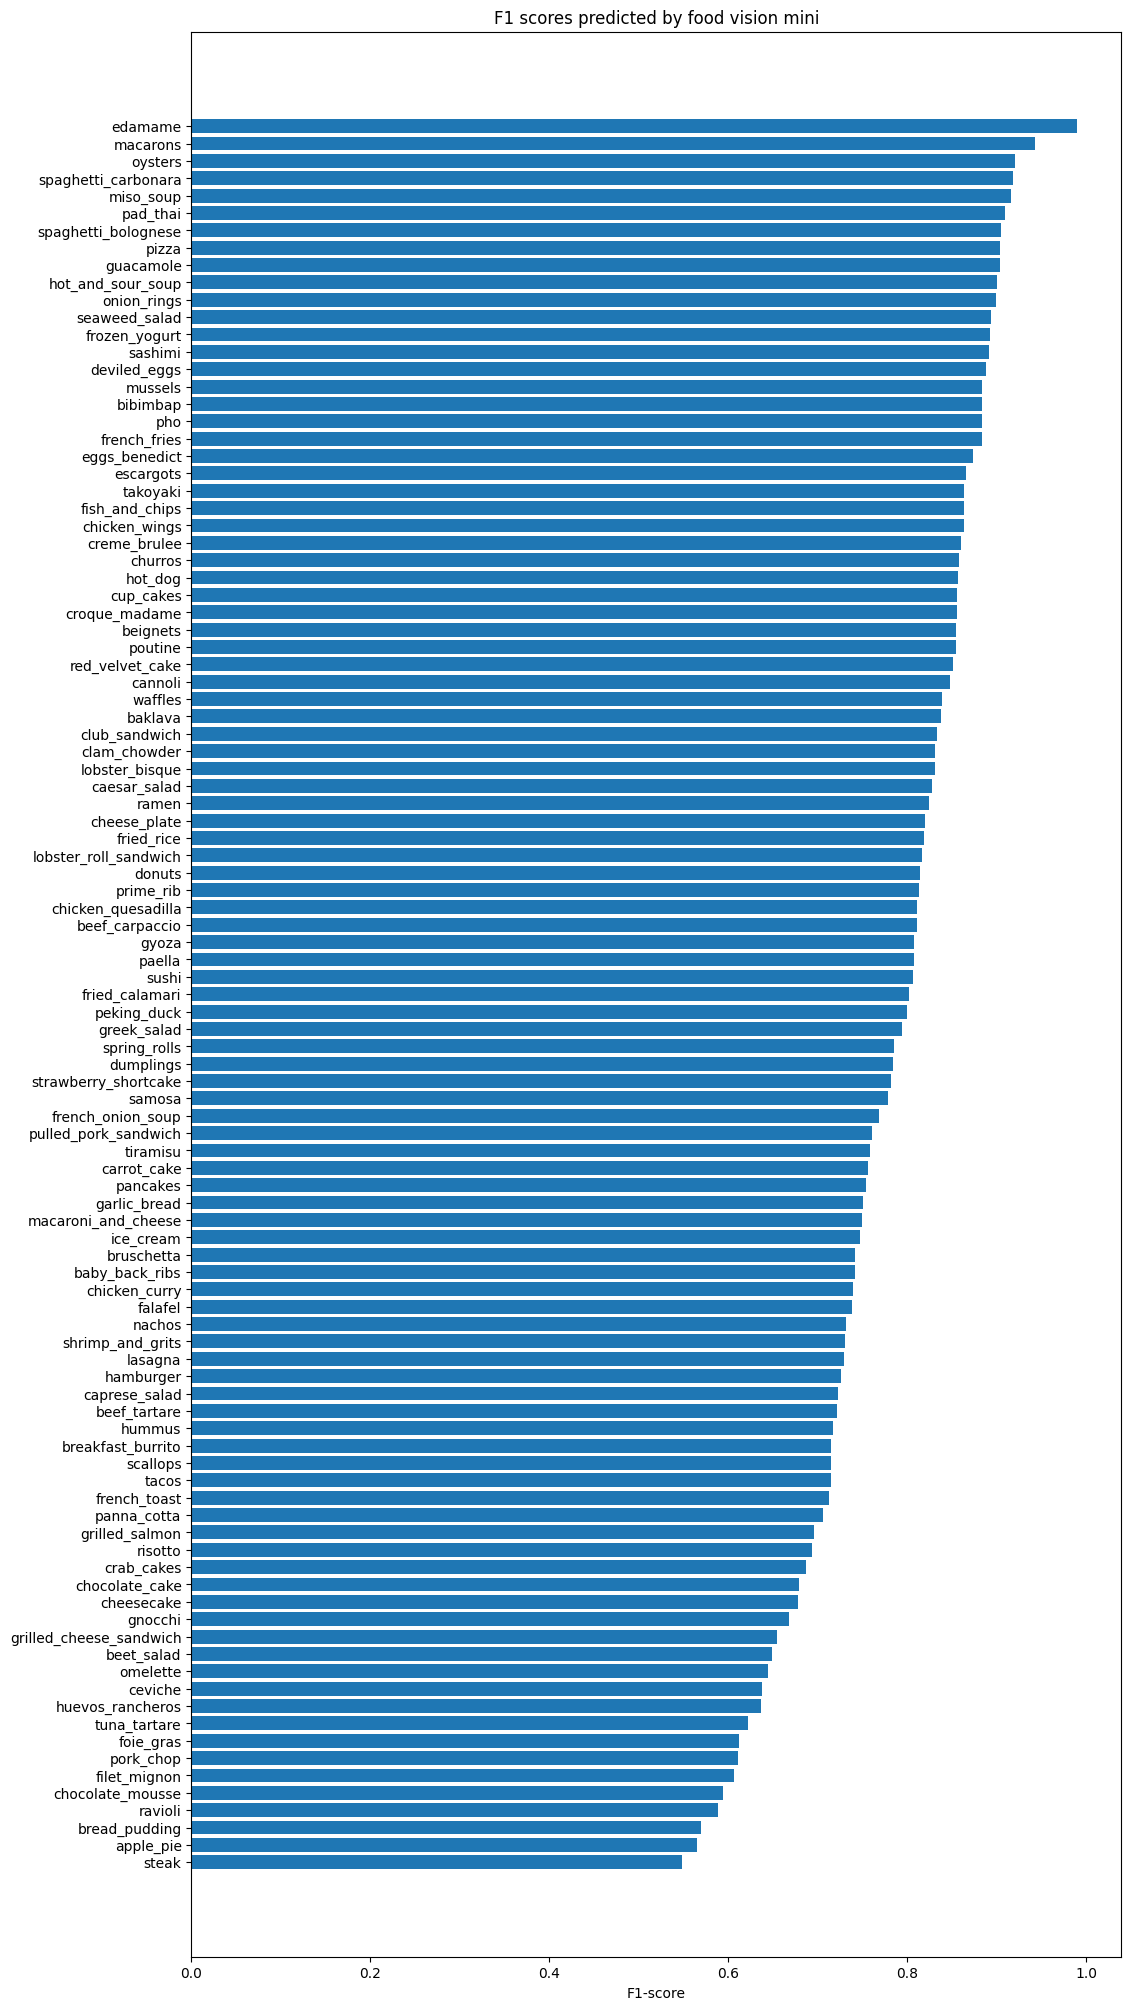

In [51]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12,25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"])
ax.set_xlabel("F1-score")
ax.set_title("F1 scores predicted by food vision mini")
ax.invert_yaxis()

In [55]:
def load_and_prep_image(img, img_shape=224, scale = True):
  #img = tf.io.read_file(filename=filename)

  #img = tf.io.decode_image(img, channels = 3)

  img = tf.image.resize(img, size=([img_shape, img_shape]))

  if scale:
    return img/255.
  else:
    return img

7/7 [==============================] - 0s 11ms/step
44


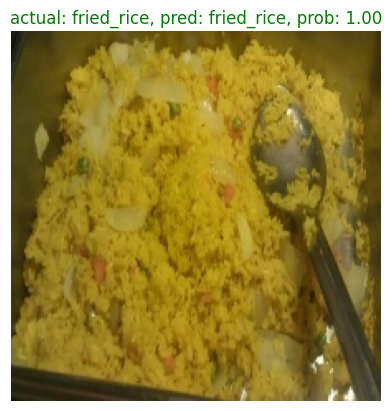

7/7 [==============================] - 0s 9ms/step
92


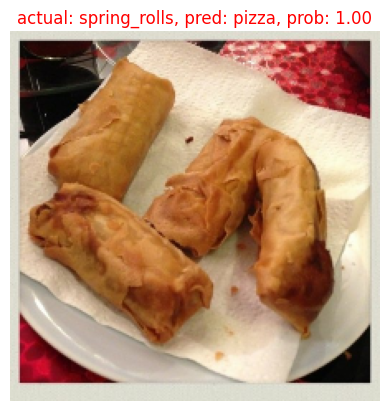

7/7 [==============================] - 0s 11ms/step
62


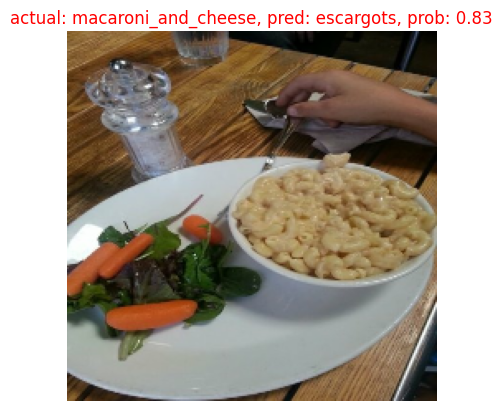

7/7 [==============================] - 0s 11ms/step
40


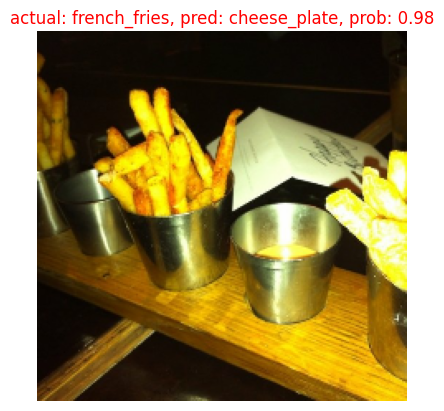

In [143]:
import os
import random
import numpy as np


#plt.figure(figsize = (17,10))
#for i in range(3):
#for i in range(3):
test_one_sample = test_data_unshuffled.take(4)

    #train_one_sample
    #numpy_images = []
    #numpy_labels = []
for image, label in test_one_sample:


    #print(numpy_images)
    #print(numpy_labels)
  img = load_and_prep_image(image, scale = False)
  img = img[-1,:,:,:]
    #print(img.shape)
    #plt.imshow(img/255.)
  img_expanded = tf.expand_dims(image, axis = 0)
    #print(img_expanded.shape)
  pred_prob = model.predict(img)
    #print(pred_prob.size)
  pred_class = class_names[pred_prob[1].argmax()]
    #print(pred_class)
  label = np.array(label)[-1]
  print(label)
    #plt.subplot(1,3,i+1)
  plt.imshow(img/255.)
  if label == pred_prob[1].argmax():
    title_color = 'g'
  else:
    title_color = 'r'
  plt.title(f"actual: {class_names[label]}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c = title_color)
  plt.axis(False)
  plt.show()

In [147]:
def load_and_prep_image(filename, img_shape=224, scale = True):
  img = tf.io.read_file(filename=filename)

  img = tf.io.decode_image(img, channels = 3)

  img = tf.image.resize(img, size=([img_shape, img_shape]))

  if scale:
    return img/255.
  else:
    return img

--2024-05-16 06:19:32--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.127.207, 172.217.218.207, 142.251.31.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.127.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip.2’

custom_food_images. 100%[===================>]  12.58M  13.8MB/s    in 0.9s    

2024-05-16 06:19:33 (13.8 MB/s) - ‘custom_food_images.zip.2’ saved [13192985/13192985]

1/1 [==============================] - 0s 26ms/step


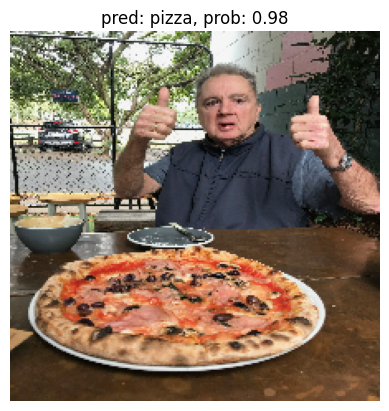

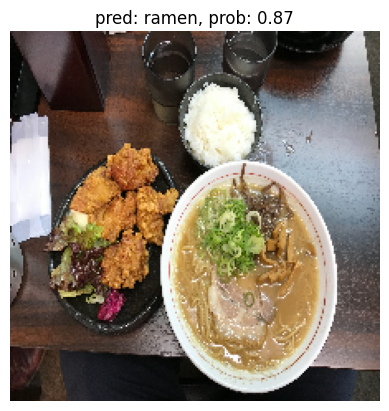

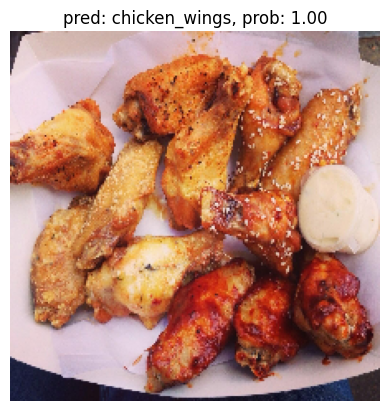

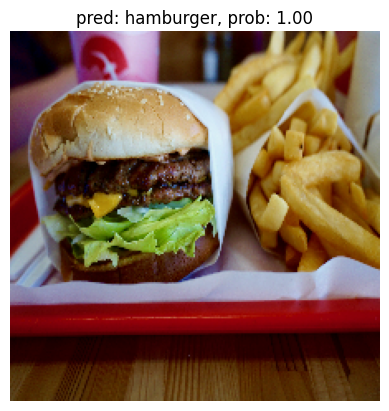

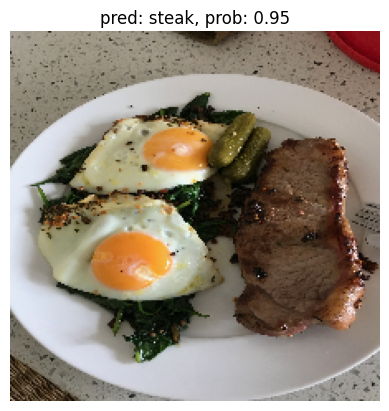

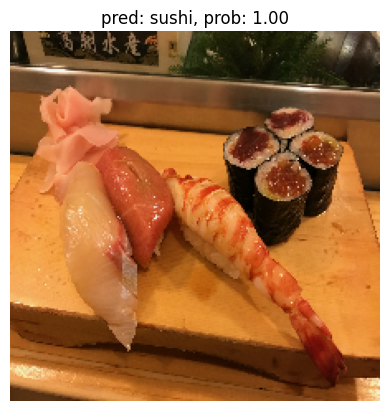

In [148]:
#test custom images:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
from helper_functions import unzip_data
unzip_data("custom_food_images.zip")


# Get custom food images filepaths
custom_food_images = ["custom_food_images/" + img_path for img_path in os.listdir("custom_food_images")]
custom_food_images

for img in custom_food_images:
  img = load_and_prep_image(img, scale = False)
  pred_prob = model.predict(tf.expand_dims(img, axis=0))
  pred_class = class_names[pred_prob.argmax()]

  plt.figure()
  plt.imshow(img/255.)
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False)